In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import glob
import numpy as np
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer,SpearmanCorrelationEliminator

In [45]:
#ファイル読み込み
df = pd.DataFrame()
for i in glob.glob("train/*.csv*"):
    tmp_df=pd.read_csv(i)
    df = pd.concat([df, tmp_df],ignore_index=True)

C:\Users\osako\AppData\Local\Temp\ipykernel_14392\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_14392\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_14392\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_14392\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)


In [46]:
#欠損値確認,欠損値削除
df_rownum=df.shape[0]
df_null_column=df.columns[df.isnull().sum()==df_rownum]
df=df.drop(df_null_column,axis=1)

In [47]:
df.drop(['ID',
         '種類',
#                '地区名',
#                '最寄駅：名称',
        '市区町村コード',
#                '用途',
#                '市区町村名',
#                '間取り',
#                '建物の構造',
#                '都市計画'
              ],inplace=True,axis=1)
df["取引の事情等"].fillna(0, inplace=True)
df.loc[df["取引の事情等"] != 0, "取引の事情等"] = 1

In [48]:
#欠損値の多い列を削除
df=df.drop(['今後の利用目的'],axis=1)
#各列のユニークな値を抽出a
unique_value=df.apply(pd.Series.unique)
# print(unique_value['都道府県名'])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)

In [49]:
df_edit1=df.copy()
df_edit1.dropna(inplace=True)
df_edit1.reset_index(drop=True, inplace=True)

In [50]:
val_min_idx = min(df_edit1[df_edit1['取引時点'].str.contains('2021年第4四半期|2022年第1四半期', regex=True)].index)
# test_min_idx = min(df[df['取引時点'].str.contains('2022年第2四半期|2022年第3四半期', regex=True)].index)
val_min_idx
# test_min_idx

547549

In [51]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df_edit1['取引時点_enc'] = df_edit1['取引時点'].map(enc_dic)

In [52]:
# TARGET = '取引価格（総額）_log'
# te_dic = {}
# time_col = '取引時点_enc'
# group_col = '都道府県名'
# for i in set(df_edit1[time_col].values):
#     #'取引時点_encがiより小さい行だけ取り出されている
#     #各年の四半期までの平均ではなく、その時点までの平均を計算しています。
#     tmp_df = df_edit1[df_edit1[time_col] < i]
#     te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

In [53]:
#編集
TARGET = '取引価格（総額）_log'
te_dic2 = {}
time_col = '取引時点_enc'
group_col = '市区町村名'
for i in set(df_edit1[time_col].values):
    #'取引時点_encがiより小さい行だけ取り出されている
    #各年の四半期までの平均ではなく、その時点までの平均を計算しています。
    tmp_df = df_edit1[df_edit1[time_col] < i]
    te_dic2[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

In [54]:
# #編集
# TARGET = '取引価格（総額）_log'
# te_dic3 = {}
# time_col = '取引時点_enc'
# group_col = '地区名'
# for i in set(df_edit1[time_col].values):
#     #'取引時点_encがiより小さい行だけ取り出されている
#     #各年の四半期までの平均ではなく、その時点までの平均を計算しています。
#     tmp_df = df_edit1[df_edit1[time_col] < i]
#     te_dic3[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

In [55]:
# TARGET = '取引価格（総額）_log'
# time_col = '取引時点_enc'
# group_col = '都道府県名'
# def calc_te(row):
#     #辞書の中のdfの'取引時点_enc'かつ四半期の都道府県
#     if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
#         return te_dic[row[time_col]][row[group_col]]
#     else:
#         return 0

# df_edit1[group_col+'_te'] = df_edit1.apply(calc_te, axis=1)

In [56]:
TARGET = '取引価格（総額）_log'
time_col = '取引時点_enc'
group_col = '市区町村名'
def calc_te(row):
    #辞書の中のdfの'取引時点_enc'かつ四半期の都道府県
    if row[time_col] in te_dic2 and row[group_col] in te_dic2[row[time_col]]:
        return te_dic2[row[time_col]][row[group_col]]
    else:
        return 0

df_edit1[group_col+'_te'] = df_edit1.apply(calc_te, axis=1)
# df_edit1.head(2)

In [57]:
# TARGET = '取引価格（総額）_log'
# time_col = '取引時点_enc'
# group_col = '地区名'
# def calc_te(row):
#     #辞書の中のdfの'取引時点_enc'かつ四半期の都道府県
#     if row[time_col] in te_dic3 and row[group_col] in te_dic3[row[time_col]]:
#         return te_dic3[row[time_col]][row[group_col]]
#     else:
#         return 0

# df_edit1[group_col+'_te'] = df_edit1.apply(calc_te, axis=1)
# # df_edit1.head(2)

In [58]:
df_edit1.loc[df_edit1['建築年']=='戦前','建築年']='昭和20年'
df_edit1['和暦名称']=df_edit1['建築年'].str[:2]
df_edit1['西暦']=df_edit1['建築年'].str[2:-1]
df_edit1['西暦'].unique()
df_edit1['西暦']=df_edit1['西暦'].astype(float)
# print(df_edit1['西暦'].unique())
df_edit1.loc[df_edit1['和暦名称']=='昭和','西暦']+=1925
df_edit1.loc[df_edit1['和暦名称']=='平成','西暦']+=1988
df_edit1.loc[df_edit1['和暦名称']=='令和','西暦']+=2018
# print(df_edit1)
df_edit1.drop(['和暦名称','建築年'],inplace=True,axis=1)
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='30分?60分','最寄駅：距離（分）']=45
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='1H?1H30','最寄駅：距離（分）']=75
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='1H30?2H','最寄駅：距離（分）']=105
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='2H?','最寄駅：距離（分）']=120
df_edit1['取引時点年数']=df_edit1['取引時点'].str[:4]
df_edit1['四半期']=df_edit1['取引時点'].str[5:]
df_edit1.loc[df_edit1['四半期']=='第2四半期','取引時点年数']+='.25'
df_edit1.loc[df_edit1['四半期']=='第3四半期','取引時点年数']+='.5'
df_edit1.loc[df_edit1['四半期']=='第4四半期','取引時点年数']+='.75'
df_edit1.drop(['取引時点'],
#                '四半期'],
              inplace=True,axis=1)

In [59]:
df_edit1.loc[df_edit1['面積（㎡）']=='2000㎡以上','面積（㎡）']='2000'
df_edit1['最寄駅：距離（分）']=df_edit1['最寄駅：距離（分）'].astype(float)
df_edit1['面積（㎡）']=df_edit1['面積（㎡）'].astype(int)
df_edit1['西暦']=df_edit1['西暦'].astype(float)
df_edit1['取引時点年数']=df_edit1['取引時点年数'].astype(float)
df_edit1['容積率（％）']=df_edit1['容積率（％）'].astype(float)
df_edit1['建ぺい率（％）']=df_edit1['建ぺい率（％）'].astype(float)
df_edit1['取引価格（総額）_log']=df_edit1['取引価格（総額）_log'].astype(float)

In [60]:
df_test=df_edit1['取引価格（総額）_log']
df_edit1.drop('取引価格（総額）_log',inplace=True,axis=1)

In [61]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df_edit1, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,7419,7419,7419,7419,7.440221,47.131015,66.953767,297.484836,0.0,10,40.0,80.0,120.0,155,80.0,800.0
1,5891,5891,5891,5891,5.372433,41.398744,74.041759,462.705822,0.0,10,60.0,100.0,20.0,1300,80.0,600.0


In [62]:
agg_dfs2 = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df_edit1,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

group_col = '地区名'
agg_dfs2.append(get_agg_df(df_edit1, group_col))
agg_dfs2[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_地区名,agg_count_面積（㎡）_grpby_地区名,agg_count_建ぺい率（％）_grpby_地区名,agg_count_容積率（％）_grpby_地区名,agg_mean_最寄駅：距離（分）_grpby_地区名,agg_mean_面積（㎡）_grpby_地区名,agg_mean_建ぺい率（％）_grpby_地区名,agg_mean_容積率（％）_grpby_地区名,agg_min_最寄駅：距離（分）_grpby_地区名,agg_min_面積（㎡）_grpby_地区名,agg_min_建ぺい率（％）_grpby_地区名,agg_min_容積率（％）_grpby_地区名,agg_max_最寄駅：距離（分）_grpby_地区名,agg_max_面積（㎡）_grpby_地区名,agg_max_建ぺい率（％）_grpby_地区名,agg_max_容積率（％）_grpby_地区名
0,446,446,446,446,15.343049,64.607623,59.618834,200.000000,4.0,15,50.0,200.0,45.0,105,60.0,200.0
1,661,661,661,661,6.384266,45.741301,69.016641,457.488654,0.0,15,60.0,200.0,13.0,180,80.0,600.0


In [63]:
# agg_dfs3 = []

# def get_agg_df(df, group_col):

#     agg_df, agg_cols = aggregation(df,
#                         group_key=group_col,
#                         group_values=['市区町村名_te', '面積（㎡）'],
#                         agg_methods=['mean'],
#                         )

#     return agg_df[agg_cols]

# group_col = '取引時点_enc'
# agg_dfs3.append(get_agg_df(df_edit1, group_col))
# agg_dfs3[0].head(2)

In [64]:
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df=concat_combi.fit_transform(df_edit1[['都道府県名', '最寄駅：距離（分）','間取り']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=3)
# concat_df2=concat_combi.fit_transform(df_edit1[['都道府県名', '最寄駅：距離（分）','間取り']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df3=concat_combi.fit_transform(df_edit1[['市区町村名', '最寄駅：距離（分）']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df4=concat_combi.fit_transform(df_edit1[['西暦', '最寄駅：距離（分）']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df5=concat_combi.fit_transform(df_edit1[['最寄駅：距離（分）', '最寄駅：名称']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=3)
# concat_df6=concat_combi.fit_transform(df_edit1[['西暦', '取引時点年数','都道府県名','市区町村名']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df3=concat_combi.fit_transform(df_edit1[['都道府県名', '西暦']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df=concat_combi.fit_transform(df_edit1[['市区町村名_te', '間取り']].astype(str))

In [65]:
### ArithmeticCombinationsの適用
arithmetic_combinations = ArithmeticCombinations(
    operator='*',
    drop_origin=True,  
    # 元の特徴量を削除するかどうか

    # 使用する算術演算子
    r=2,
    # 算術演算子の数（ここでは2つの特徴量を組み合わせる）
)
output_df = arithmetic_combinations.fit_transform(df_edit1[['市区町村名_te', '面積（㎡）']])
# ArithmeticCombinationsの適用
arithmetic_combinations = ArithmeticCombinations(
    operator='/',
    drop_origin=True,  
    # 元の特徴量を削除するかどうか

    # 使用する算術演算子
    r=2,
    # 算術演算子の数（ここでは2つの特徴量を組み合わせる）
)
# output_df2 = arithmetic_combinations.fit_transform(df_edit1[['地区名,'面積（㎡）']])

In [66]:
df_edit2=pd.concat([df_edit1, 
                    output_df,
#                    output_df2
#                     concat_df
                   ]
#                    concat_df2,concat_df3,concat_df4,concat_df5,concat_df6]
                   +agg_dfs+agg_dfs2,
#                     +agg_dfs3,
                   axis=1)
# print(feat_df.shape)

In [67]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])
le_df = encoder.fit_transform(df_edit2)
le_df.head(2)

c:\users\osako\pycharmprojects\pythonproject2\venv\lib\site-packages\xfeat\cat_encoder\_basic_encoder.py:93: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  labels, uniques = input_df[col].factorize(sort=self._sort_category)


,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,都市計画,改装,取引の事情等,四半期
0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,0,1,1,0,0


In [68]:
encoder = Pipeline(
    [
        SelectNumerical(),
    ]
)

num_comb_df = encoder.fit_transform(df_edit2)
num_comb_df.head(2)

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引時点_enc,市区町村名_te,西暦,取引時点年数,市区町村名_te面積（㎡）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,...,agg_mean_建ぺい率（％）_grpby_地区名,agg_mean_容積率（％）_grpby_地区名,agg_min_最寄駅：距離（分）_grpby_地区名,agg_min_面積（㎡）_grpby_地区名,agg_min_建ぺい率（％）_grpby_地区名,agg_min_容積率（％）_grpby_地区名,agg_max_最寄駅：距離（分）_grpby_地区名,agg_max_面積（㎡）_grpby_地区名,agg_max_建ぺい率（％）_grpby_地区名,agg_max_容積率（％）_grpby_地区名
0,12.0,70,60.0,200.0,0,0.0,1978.0,2005.5,0.0,7419,...,59.618834,200.000000,4.0,15,50.0,200.0,45.0,105,60.0,200.0
1,11.0,20,80.0,600.0,0,0.0,2005.0,2005.5,0.0,5891,...,69.016641,457.488654,0.0,15,60.0,200.0,13.0,180,80.0,600.0


In [136]:
df_dummy=pd.concat([num_comb_df,le_df],axis=1)

In [137]:
# from sklearn.preprocessing import OrdinalEncoder
# oe = OrdinalEncoder()

# labels = df_edit1[[
# #     '市区町村コード',
#     '都道府県名',
#     '市区町村名',
#     '最寄駅：名称',
#      '間取り',
#      '建物の構造',
#     '地区名',
#      '用途',
#     '都市計画',
#     '四半期',
#     '改装']].values
# labels_id = oe.fit_transform(labels)
# # df_dummy = pd.concat([df_edit1, labels_id], axis=1)
# # df_dummy.drop(['都道府県名', 
# #                '市区町村名',
# #                '間取り',
# #                 '建物の構造',
# #                 '都市計画',
# #                '改装'],axis=1,inplace=True)
# df_dummy = pd.concat([df_edit1.reset_index(drop=True), pd.DataFrame(labels_id)], axis=1)
# df_dummy.drop(['都道府県名',
#                '市区町村名', 
#                '四半期',
#                '間取り', 
#                '建物の構造', 
#                '都市計画',
#                '最寄駅：名称',
#                '地区名',
#                '用途',
#                '改装'], axis=1, inplace=True)
# print(labels_id.shape) 

In [138]:
# df_dummy['面積（㎡）log']=np.log(df_dummy['面積（㎡）'])
# df_dummy['面積（㎡）log'].replace([np.inf, -np.inf], np.nan, inplace=True)
# df_dummy['面積（㎡）log'].fillna(0,inplace=True)

In [139]:
# df_dummy['最寄駅：距離（分）log']=np.log(df_dummy['最寄駅：距離（分）'])
# df_dummy['最寄駅：距離（分）log'].replace([np.inf, -np.inf], np.nan, inplace=True)
# df_dummy['最寄駅：距離（分）log'].fillna(0,inplace=True)

In [140]:
df_dummy['建ぺい率×容積率']=df_dummy['建ぺい率（％）']*df_dummy['容積率（％）']
df_dummy['敷地面積']=df_dummy['面積（㎡）']/df_dummy['建ぺい率（％）']*100
df_dummy['延べ床面積']=df_dummy['容積率（％）']/100*df_dummy['敷地面積']
df_dummy['年差']=df_dummy['西暦']-df_dummy['取引時点年数']
df_dummy.isnull().sum()

最寄駅：距離（分）                          0
面積（㎡）                              0
建ぺい率（％）                            0
容積率（％）                             0
取引時点_enc                           0
市区町村名_te                           0
西暦                                 0
取引時点年数                             0
市区町村名_te面積（㎡）_combi                0
agg_count_最寄駅：距離（分）_grpby_市区町村名    0
agg_count_面積（㎡）_grpby_市区町村名        0
agg_count_建ぺい率（％）_grpby_市区町村名      0
agg_count_容積率（％）_grpby_市区町村名       0
agg_mean_最寄駅：距離（分）_grpby_市区町村名     0
agg_mean_面積（㎡）_grpby_市区町村名         0
agg_mean_建ぺい率（％）_grpby_市区町村名       0
agg_mean_容積率（％）_grpby_市区町村名        0
agg_min_最寄駅：距離（分）_grpby_市区町村名      0
agg_min_面積（㎡）_grpby_市区町村名          0
agg_min_建ぺい率（％）_grpby_市区町村名        0
agg_min_容積率（％）_grpby_市区町村名         0
agg_max_最寄駅：距離（分）_grpby_市区町村名      0
agg_max_面積（㎡）_grpby_市区町村名          0
agg_max_建ぺい率（％）_grpby_市区町村名        0
agg_max_容積率（％）_grpby_市区町村名         0
agg_count_最寄駅：距離（分）_grpby_地区名      0
agg_count_面積（㎡）_grpby_地区名          0
a

In [141]:
df_dummy.columns = df_dummy.columns.astype(str)

In [142]:
df_dummy.drop(df_dummy[['agg_count_容積率（％）_grpby_市区町村名','agg_count_面積（㎡）_grpby_市区町村名','agg_count_建ぺい率（％）_grpby_市区町村名','取引時点年数','四半期',
                        'agg_count_容積率（％）_grpby_地区名',
                        'agg_count_建ぺい率（％）_grpby_地区名',
                        'agg_count_面積（㎡）_grpby_地区名',
                       ]],axis=1,inplace=True)

In [143]:
# corr_eliminator = SpearmanCorrelationEliminator()
# df_dummy=corr_eliminator.fit_transform(df_dummy)

In [144]:
df_dummy['建ぺい率×容積率_市区町村別']=df_dummy['agg_mean_建ぺい率（％）_grpby_市区町村名']*df_dummy['agg_mean_容積率（％）_grpby_市区町村名']
df_dummy['敷地面積_市区町村別']=df_dummy['agg_mean_面積（㎡）_grpby_市区町村名']/df_dummy['agg_mean_建ぺい率（％）_grpby_市区町村名']*100
df_dummy['延べ床面積_市区町村別']=df_dummy['agg_mean_容積率（％）_grpby_市区町村名']/100*df_dummy['敷地面積_市区町村別']

In [145]:
df_dummy.drop(df_dummy[['敷地面積_市区町村別'
                       ]],axis=1,inplace=True)

In [146]:
X_train=df_dummy.iloc[:val_min_idx,:]
y_train=df_test.iloc[:val_min_idx]
X_test=df_dummy.iloc[val_min_idx:,:]
y_test=df_test.iloc[val_min_idx:]

In [147]:
X_test

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引時点_enc,市区町村名_te,西暦,市区町村名_te面積（㎡）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,...,用途,都市計画,改装,取引の事情等,建ぺい率×容積率,敷地面積,延べ床面積,年差,建ぺい率×容積率_市区町村別,延べ床面積_市区町村別
547549,16.0,70,60.0,200.0,65,7.093400,2001.0,496.538006,1100,14.216364,...,0,0,0,0,12000.0,116.666667,233.333333,-20.75,15865.526033,275.093081
547550,4.0,70,60.0,200.0,65,7.367739,1974.0,515.741720,11514,7.152857,...,0,4,0,0,12000.0,116.666667,233.333333,-47.75,19599.531776,187.247420
547551,13.0,75,80.0,300.0,65,7.171199,2012.0,537.839929,1073,10.933830,...,0,2,0,0,24000.0,93.750000,281.250000,-9.75,12706.614443,238.522064
547552,45.0,110,60.0,300.0,65,7.154824,2007.0,787.030654,2094,15.596944,...,0,0,0,0,18000.0,183.333333,550.000000,-14.75,12752.987888,243.829975
547553,5.0,55,80.0,500.0,65,7.367739,1984.0,405.225637,11514,7.152857,...,0,1,0,0,40000.0,68.750000,343.750000,-37.75,19599.531776,187.247420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564688,18.0,85,60.0,200.0,66,7.309047,2021.0,621.269027,4359,12.079147,...,0,0,1,0,12000.0,141.666667,283.333333,-1.00,15523.941143,273.499001
564689,25.0,25,60.0,200.0,66,6.480037,1974.0,162.000918,290,35.565517,...,0,9,1,0,12000.0,41.666667,83.333333,-48.00,11965.541023,176.048073
564690,2.0,25,80.0,300.0,66,7.507058,2011.0,187.676439,9650,8.885078,...,0,2,1,0,24000.0,31.250000,93.750000,-11.00,15436.956508,199.583116
564691,13.0,55,60.0,200.0,66,7.109867,1982.0,391.042702,522,24.111111,...,0,8,0,0,12000.0,91.666667,183.333333,-40.00,18644.470868,276.893353


In [148]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=30, random_state=0,verbose=1, n_init=200).fit(X_train)
# X_train_kmeans=kmeans.predict(X_train)
# X_test_kmeans=kmeans.predict(X_test)
# X_test.reset_index(drop=True, inplace=True)
# sr1 = pd.Series(X_train_kmeans)
# sr2=pd.Series(X_test_kmeans)
# X_train=pd.concat([X_train,sr1],axis=1)
# X_test=pd.concat([X_test,sr2],axis=1)

In [153]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

xgb_params = {
    'objective': 'reg:linear',
    'learning_rate': 0.1,
    'reg_lambda': 1,
    'max_depth': 8,
    'seed': 123
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = np.array(y_train)  # Convert y_train to numpy array
y_test = np.array(y_test)  # Convert y_test to numpy array

dtrain = xgb.DMatrix(X_train_scaled, label=y_train,feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test_scaled, label=y_test,feature_names=X_train.columns)  # Provide labels for evaluation

evals = [(dtrain, 'train'), (dtest, 'eval')]

model = xgb.train(xgb_params, dtrain, num_boost_round=400,
                  early_stopping_rounds=20, evals=evals, verbose_eval=True)

y_pred_train = model.predict(dtrain)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Train RMSE:", rmse_train)

y_pred_test = model.predict(dtest)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)


[22:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:6.06809	eval-rmse:6.17893
[1]	train-rmse:5.46193	eval-rmse:5.56815
[2]	train-rmse:4.91641	eval-rmse:5.01840
[3]	train-rmse:4.42550	eval-rmse:4.52375
[4]	train-rmse:3.98371	eval-rmse:4.07787
[5]	train-rmse:3.58614	eval-rmse:3.67651
[6]	train-rmse:3.22840	eval-rmse:3.31565
[7]	train-rmse:2.90648	eval-rmse:2.99060
[8]	train-rmse:2.61682	eval-rmse:2.69818
[9]	train-rmse:2.35620	eval-rmse:2.43484
[10]	train-rmse:2.12173	eval-rmse:2.19769
[11]	train-rmse:1.91079	eval-rmse:1.98404
[12]	train-rmse:1.72104	eval-rmse:1.79190
[13]	train-rmse:1.55037	eval-rmse:1.61879
[14]	train-rmse:1.39689	eval-rmse:1.46284
[15]	train-rmse:1.25890	eval-rmse:1.32243
[16]	train-rmse:1.13486	eval-rmse:1.19635
[17]	train-rmse:1.02340	eval-rmse:1.08337
[18]	train-rmse:0.92325

[188]	train-rmse:0.11828	eval-rmse:0.12500
[189]	train-rmse:0.11825	eval-rmse:0.12499
[190]	train-rmse:0.11819	eval-rmse:0.12497
[191]	train-rmse:0.11816	eval-rmse:0.12496
[192]	train-rmse:0.11815	eval-rmse:0.12495
[193]	train-rmse:0.11809	eval-rmse:0.12492
[194]	train-rmse:0.11800	eval-rmse:0.12487
[195]	train-rmse:0.11794	eval-rmse:0.12486
[196]	train-rmse:0.11786	eval-rmse:0.12483
[197]	train-rmse:0.11783	eval-rmse:0.12482
[198]	train-rmse:0.11776	eval-rmse:0.12477
[199]	train-rmse:0.11770	eval-rmse:0.12476
[200]	train-rmse:0.11763	eval-rmse:0.12475
[201]	train-rmse:0.11760	eval-rmse:0.12473
[202]	train-rmse:0.11758	eval-rmse:0.12474
[203]	train-rmse:0.11755	eval-rmse:0.12485
[204]	train-rmse:0.11749	eval-rmse:0.12483
[205]	train-rmse:0.11746	eval-rmse:0.12482
[206]	train-rmse:0.11743	eval-rmse:0.12484
[207]	train-rmse:0.11740	eval-rmse:0.12480
[208]	train-rmse:0.11739	eval-rmse:0.12478
[209]	train-rmse:0.11734	eval-rmse:0.12474
[210]	train-rmse:0.11729	eval-rmse:0.12472
[211]	train

[379]	train-rmse:0.11083	eval-rmse:0.12334
[380]	train-rmse:0.11076	eval-rmse:0.12331
[381]	train-rmse:0.11071	eval-rmse:0.12328
[382]	train-rmse:0.11068	eval-rmse:0.12328
[383]	train-rmse:0.11064	eval-rmse:0.12326
[384]	train-rmse:0.11062	eval-rmse:0.12326
[385]	train-rmse:0.11060	eval-rmse:0.12325
[386]	train-rmse:0.11059	eval-rmse:0.12326
[387]	train-rmse:0.11055	eval-rmse:0.12324
[388]	train-rmse:0.11052	eval-rmse:0.12322
[389]	train-rmse:0.11048	eval-rmse:0.12324
[390]	train-rmse:0.11043	eval-rmse:0.12322
[391]	train-rmse:0.11042	eval-rmse:0.12320
[392]	train-rmse:0.11041	eval-rmse:0.12320
[393]	train-rmse:0.11040	eval-rmse:0.12321
[394]	train-rmse:0.11040	eval-rmse:0.12321
[395]	train-rmse:0.11037	eval-rmse:0.12320
[396]	train-rmse:0.11031	eval-rmse:0.12320
[397]	train-rmse:0.11026	eval-rmse:0.12319
[398]	train-rmse:0.11022	eval-rmse:0.12317
[399]	train-rmse:0.11019	eval-rmse:0.12317
Train RMSE: 0.11019018453371136
Test RMSE: 0.1231658194932549
Test MAE: 0.07663615427529097


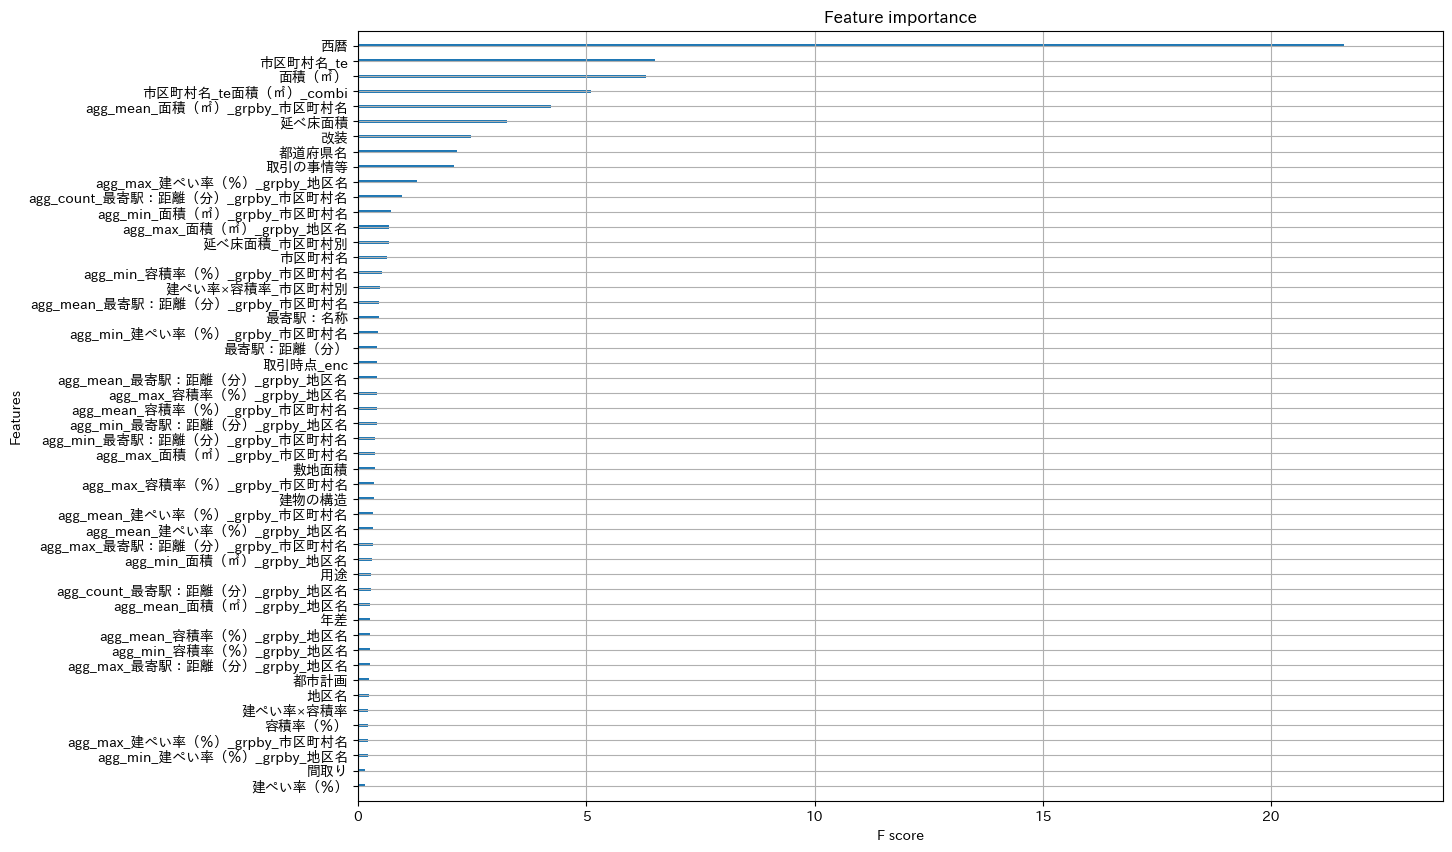

In [152]:
# fig, ax = plt.subplots(figsize=(12, 8))
# xgb.plot_importance(model, importance_type='gain', xlabel='Importance (Gain)', show_values=False)
# plt.show()
_, ax = plt.subplots(figsize=(14, 10))
xgb.plot_importance(model,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)
plt.show()

In [43]:
X_train

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引時点_enc,市区町村名_te,西暦,市区町村名_te面積（㎡）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,...,間取り,建物の構造,用途,都市計画,改装,取引の事情等,建ぺい率×容積率,敷地面積,延べ床面積,年差
0,12.0,70,60.0,200.0,0,0.000000,1978.0,0.000000,7419,7.440221,...,0,0,0,0,0,0,12000.0,116.666667,233.333333,-27.5
1,11.0,20,80.0,600.0,0,0.000000,2005.0,0.000000,5891,5.372433,...,1,1,0,1,1,0,48000.0,25.000000,150.000000,-0.5
2,8.0,20,80.0,600.0,0,0.000000,1989.0,0.000000,6167,10.715421,...,2,0,0,1,1,0,48000.0,25.000000,150.000000,-16.5
3,14.0,20,80.0,300.0,0,0.000000,1998.0,0.000000,6875,7.141236,...,1,1,0,2,1,0,24000.0,25.000000,75.000000,-7.5
4,10.0,60,60.0,200.0,0,0.000000,1984.0,0.000000,1318,10.550076,...,0,1,0,3,0,0,12000.0,100.000000,200.000000,-21.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547544,3.0,75,60.0,150.0,64,7.215887,1998.0,541.191508,1561,15.691224,...,0,1,0,0,1,0,9000.0,125.000000,187.500000,-23.5
547545,28.0,55,60.0,200.0,64,7.392088,1971.0,406.564862,2627,15.178911,...,6,1,0,0,1,0,12000.0,91.666667,183.333333,-50.5
547546,3.0,85,60.0,300.0,64,7.206771,2009.0,612.575508,763,4.370904,...,0,1,0,4,1,0,18000.0,141.666667,425.000000,-12.5
547547,45.0,65,60.0,200.0,64,7.181237,1998.0,466.780375,4051,12.143915,...,0,1,0,0,1,0,12000.0,108.333333,216.666667,-23.5


In [324]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler
import numpy as np

xgb_r = xgb.XGBRegressor(objective='reg:linear',
                         learning_rate=0.3,
                         reg_lambda=1,
                         n_estimators=400,
                         early_stopping_rounds=20,
                         max_depth=7,
                         seed=121)


# scaler = RobustScaler(quantile_range=(25.0, 75.0))
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the XGBoost model with early stopping
xgb_r.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=True)

y_pred_train = xgb_r.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
print("Train RMSE:", rmse_train)

y_pred_test = xgb_r.predict(scaler.transform(X_test))
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)

[16:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.82185
[1]	validation_0-rmse:3.39675
[2]	validation_0-rmse:2.39868
[3]	validation_0-rmse:1.70091
[4]	validation_0-rmse:1.21189
[5]	validation_0-rmse:0.86894
[6]	validation_0-rmse:0.63022
[7]	validation_0-rmse:0.46457
[8]	validation_0-rmse:0.35409
[9]	validation_0-rmse:0.27635
[10]	validation_0-rmse:0.22860
[11]	validation_0-rmse:0.19592
[12]	validation_0-rmse:0.17492
[13]	validation_0-rmse:0.16312
[14]	validation_0-rmse:0.15565
[15]	validation_0-rmse:0.15063
[16]	validation_0-rmse:0.14728
[17]	validation_0-rmse:0.14385
[18]	validation_0-rmse:0.14242
[19]	validation_0-rmse:0.14148
[20]	validation_0-rmse:0.14054
[21]	validation_0-rmse:0.13953
[22]	validation_0-rmse:0.13817
[23]	validation_0-rmse:0.13780
[24]	validation_0-rmse:0.13741
[25]

KeyboardInterrupt: 

In [78]:
# importance_scores = xgb_r.feature_importances_
# feature_names = X_train.columns

# # Display feature importance
# for feature_name, importance_score in zip(feature_names, importance_scores):
#     print(feature_name, importance_score)

In [ ]:
# importance_scores = xgb_r.get_booster().get_score(importance_type='weight')
# # 特徴量の重要度を表示
# for feature_name, importance_score in importance_scores.items():
#     print(feature_name, importance_score)

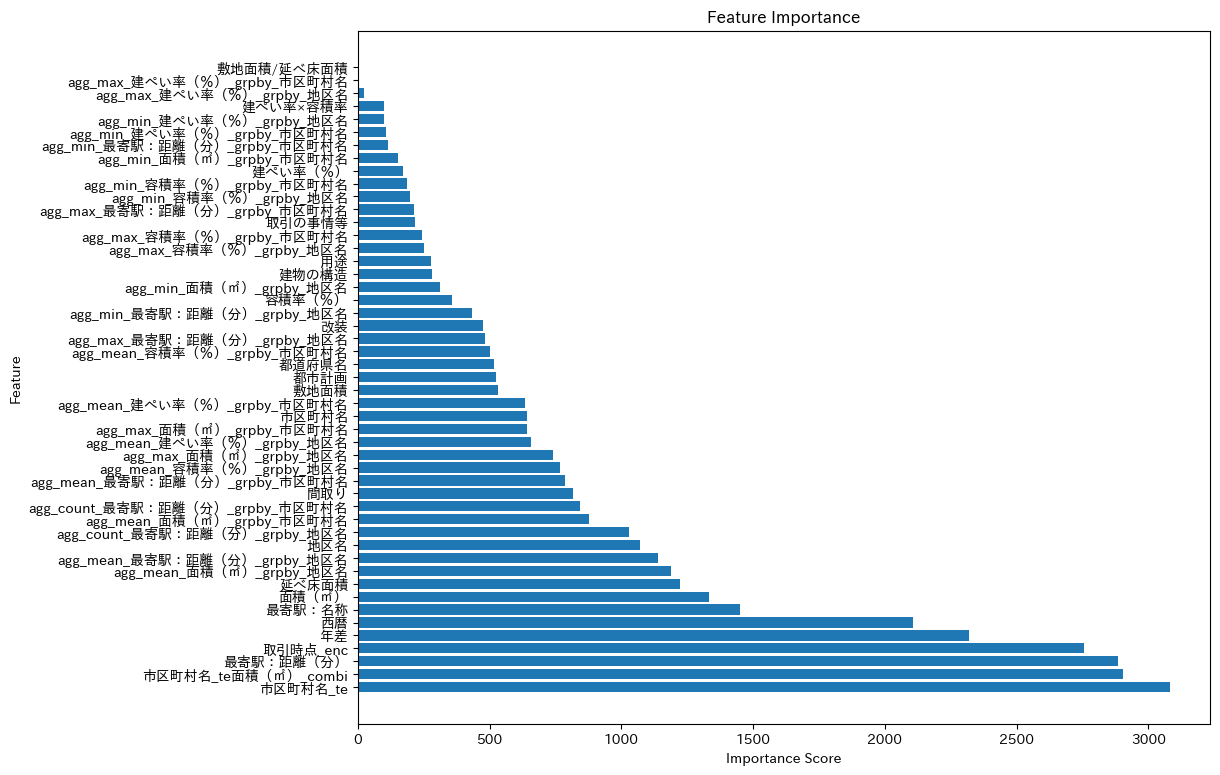

In [378]:
import matplotlib.pyplot as plt
import japanize_matplotlib

importance_scores = xgb_r.get_booster().get_score(importance_type='weight')
feature_names = X_train.columns

importance_values = [importance_scores.get('f{}'.format(i), 0) for i in range(len(feature_names))]

# 重要度の値で降順にソート
sorted_indices = sorted(range(len(importance_values)), key=lambda k: importance_values[k], reverse=True)
importance_values_sorted = [importance_values[i] for i in sorted_indices]
feature_names_sorted = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(11, 9))
plt.barh(range(len(importance_values_sorted)), importance_values_sorted, align='center')
plt.yticks(range(len(importance_values_sorted)), feature_names_sorted)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

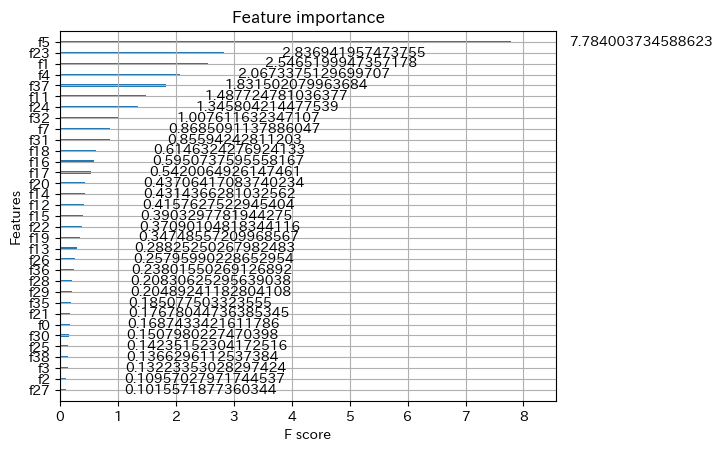

In [107]:
import matplotlib.pyplot as plt
import japanize_matplotlib
xgb.plot_importance(xgb_r,importance_type='gain')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

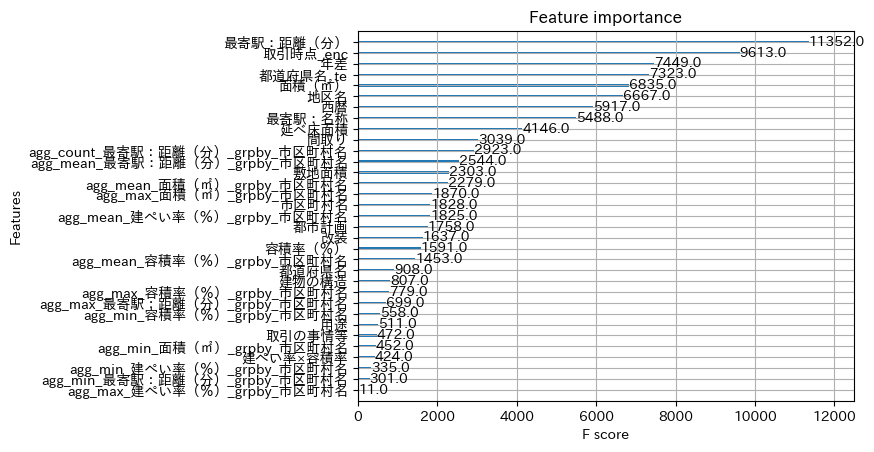

In [112]:
features =df_dummy.columns[df_dummy.any()]
mapper = {'f{0}'.format(i): v for i, v in enumerate(features)}
mapped = {mapper[k]: v for k, v in xgb_r._Booster.get_fscore().items()}
xgb.plot_importance(mapped,importance_type='cover')

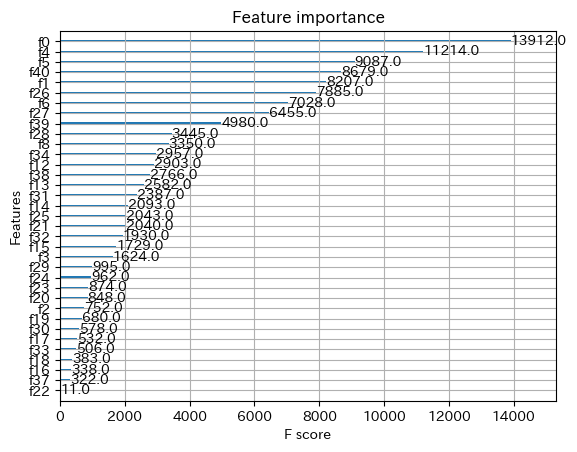

In [100]:
import matplotlib.pyplot as plt
import japanize_matplotlib
xgb.plot_importance(xgb_r,importance_type='weight')
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

xgb_r = xgb.XGBRegressor(objective='reg:linear',
                         learning_rate=0.3, 
                         reg_lambda=1,
                         n_estimators=400,
                         max_depth=8,
                         seed=123)
xgb_r.fit(X_train, y_train, 
         eval_set=[(X_test, y_test)],
         early_stopping_rounds=20)

In [ ]:
# K分割交差検証
from sklearn.model_selection import KFold
 sklearn.model_selection import KFold
# データの分割
kf = KFold(n_splits=5, shuffle=True, random_state=42)
valid_mse = []
i = 1
for train_id, test_id in kf.split(X_set):
   # モデルの学習
    pipe.fit(X_train, y_train)
    # テストデータの予測値とMSEの計算
    y_pred_test = pipe.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    # テストデータでのRMSE
    print('{}Fold テストRMSE: {}'.format(i, np.sqrt(test_mse)))  # 各Kの誤差を表示
    valid_mse.append(np.sqrt(test_mse))  # 各KのテストMSEの平均が検証誤差
    i += 1

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
xgb.plot_importance(xgb_r)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
best_model

In [ ]:

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error
from itertools import product

# Define the hyperparameter combinations
param_grid = {
    'learning_rate': [0.3, 0.6, 1],
    'max_depth': [6, 8, 11],
    'reg_lambda': [0.5, 1],
    'n_estimators': [300],
    'subsample': [0.6, 1],
    'colsample_bytree': [0.6, 1],
#     'min_child_weight': [1, 5]
}


# Initialize the best model, best parameters, and best accuracy
best_model = None
best_params = None
best_mae = float('inf') 

# Hyperparameter tuning and model evaluation
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    print(param_dict)
    # Create a pipeline with feature scaling and XGBoost classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', xgb.XGBRegressor(**param_dict))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    if mae < best_mae:
        best_mae = mae
        best_model = pipeline
        best_params = params

# Retrain the best model with the entire training set
# best_model.fit(X_train, y_train)

# # Evaluate the final model on the test set
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", accuracy)

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter combinations
param_grid = {
    'model__learning_rate': [0.3, 0.6, 1],
    'model__max_depth': [3, 6, 9, 11],
    'model__reg_lambda': [0.5, 1],
    'model__n_estimators': [200, 400, 600],
    'model__subsample': [0.5, 0.75, 1],
    'model__colsample_bytree': [0.5, 0.75, 1],
    'model__min_child_weight': [1, 5, 10],
    'model__gamma': [0, 0.1, 0.5, 1, 3]
}

# Create a pipeline with feature scaling and XGBoost regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor())
])

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model, best parameters, and best MAE
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
# y_pred = best_model.predict(X_test)
# best_mae = mean_absolute_error(y_val, y_pred)